In [1]:


%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp
from numba import jit
figsize(20,6)
prefix="voice3_0_1"
def filepre(nm):
    return "tmp/"+prefix+"_"+nm

Populating the interactive namespace from numpy and matplotlib


In [2]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


22050


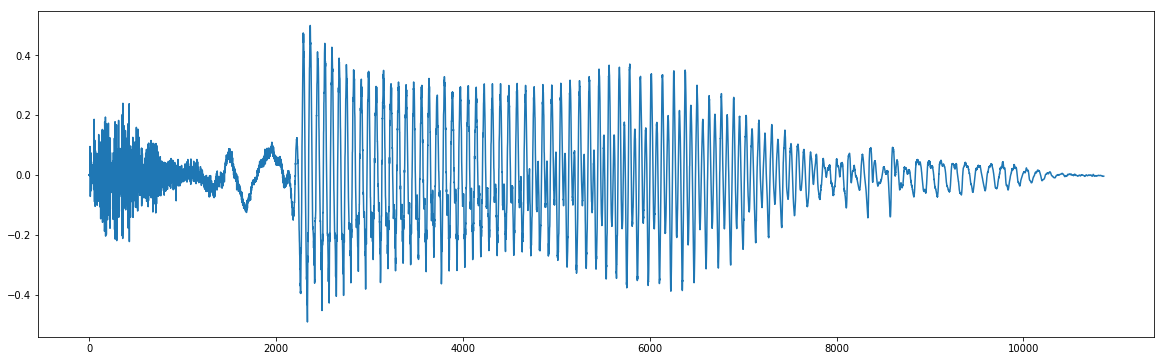

In [3]:
y, sr = librosa.load("audios/197016__margo-heston__two-f.wav")
y = y[4140:15000] 
y = y / np.max(y) * 0.5
plot(y)
print(sr)

In [4]:
Audio(data=y,rate=sr)

18
40
61
77
95
115
133
153
171
191
211
229
247
267
284
300
320
337
354
373
389
406
423
440
456
474
490
506
522
539
556
573
589
606
622
638
657
674
692
708
724
740
757
773
789
805
825
843
863
880
899
917
935
952
968
991
1008
1025
1046
1062
1078
1094
1113
1130
1149
1170
1191
1207
1363
1407
1426
1446
1547
1567
1802
2070
2118
2136
2238
2312
2385
2465
2541
2617
2693
2772
2850
2931
3007
3090
3167
3248
3329
3410
3491
3574
3655
3743
3822
3905
3990
4073
4158
4245
4333
4420
4509
4597
4688
4713
4780
4808
4874
4903
4969
5001
5067
5099
5165
5200
5268
5302
5371
5409
5475
5517
5582
5628
5692
5738
5802
5852
5918
5969
6034
6088
6154
6209
6276
6332
6398
6456
6524
6584
6654
6714
6783
6845
6914
6976
7046
7110
7183
7247
7321
7386
7460
7526
7602
7666
7743
7795
7885
7935
8031
8072
8150
8203
8298
8380
8426
8550
8625
8663
8788
8913
9039
9168
9294
9425
9554
9683
9807
9933
10058
10183
10300
10354
10433
10532
10556
10602
10640
10678
10708
10727
10753
10800
max length:  268
min length:  16


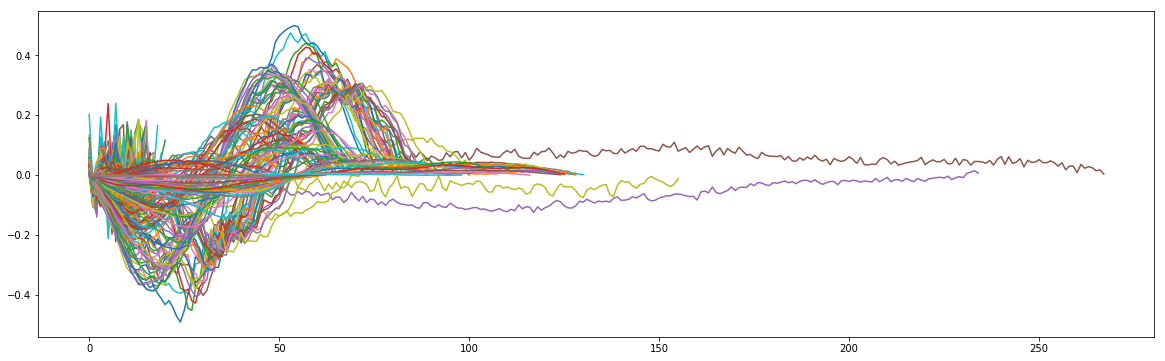

In [5]:
#divide out windows
patterns = []
    
minPatternSize = 15
lastCrossing=0
for i in range(y.shape[0]-1):
    if (i-lastCrossing) > minPatternSize and y[i] >=0 and y[i+1] < 0:
        print(i)
        segment = y[lastCrossing:i]
        patterns.append(segment)
        lastCrossing = i
#convert to numpy
patterns = np.array(patterns, dtype=np.object)
patternLengths = [x.shape[0] for x in patterns]
maxPatternLen = np.max(patternLengths)
minPatternLen = np.min(patternLengths)
print("max length: ", maxPatternLen)
print("min length: ", minPatternLen)
for p in patterns:
    plot(p)

In [6]:
def computeConceptor(p, net, i_pattern, alpha):
    print('Computing conceptor, alpha: ', alpha)
#     Cs = np.zeros((4, 1), dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = (S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(p['N']))))

    C =  U.dot(Snew).dot(U.T);
#     Cs[0,0] = C
#     Cs[1,0] = U
#     Cs[2,0] = diag(Snew)
#     Cs[3,0] = diag(S)

    return C


def testConceptor(p, C, net, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    LR = np.diag(p['LR'])
    LROneMinus = np.diag(1.0 - p['LR'])
    for i_trial in range(trials):
        x_CTestPL = np.zeros((p['N'], recallTestLength))
        z_CTestPL = np.zeros((p['N'], recallTestLength))
        x = 0.5 * np.random.randn(p['N'],1)
        z = x
        for n in range(recallTestLength + p['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            leakTerm = LROneMinus.dot(xOld)
            newX =tanh(Wtarget + net['Wbias'])
            newXLeaked = LR.dot(newX)
            z = leakTerm + newXLeaked
            x = C.dot(z)
            xPrev = x
            if (n > p['washoutLength']):
                x_CTestPL[:,n-p['washoutLength']] = x.T
                z_CTestPL[:,n-p['washoutLength']] = z.T

        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)



In [7]:
from mem_top import mem_top
print(mem_top())


refs:
5720	<class 'list'> ['# module pyparsing.py\n', '#\n', '# Copyright (c) 2003-2016  Paul T. McGuire\n', '#\n', '# Permiss
5696	<class 'list'> ['# module pyparsing.py\n', '#\n', '# Copyright (c) 2003-2016  Paul T. McGuire\n', '#\n', '# Permiss
2826	<class 'dict'> {4468881008: <weakref at 0x10a6ab638; to 'type' at 0x10a5db670 (type)>, 4468906272: <weakref at 0x10
1566	<class 'dict'> {'builtins': <module 'builtins' (built-in)>, 'sys': <module 'sys' (built-in)>, '_frozen_importlib': 
1165	<class 'matplotlib.colors._ColorMapping'> {'xkcd:cloudy blue': '#acc2d9', 'xkcd:dark pastel green': '#56ae57', 'xkcd:dust': '#b2996e', 'xkcd:e
1043	<class 'dict'> {'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environmen
1020	<class 'dict'> {'_ih': ['', '\n\nget_ipython().magic(\'pylab inline\')\nfrom IPython.display import Audio\nimport l
993	<class 'dict'> {'__name__': 'matplotlib.pylab', '__doc__': '\nThis is a procedural interface to the matplotlib obje

In [12]:
#create a random reservoir and load it with patterns using Jaeger's method

def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLength']))
    pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((1, 0));
    patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
    print('Loading patterns: ', end='')
    LR = np.diag(p['LR'])
    LROneMinus = np.diag(1.0 - p['LR'])
#     print(LR)
#     print(LROneMinus)
    for i_pattern in range(p['patts'].shape[0]):
        print(i_pattern, " ", end='')
        patt = p['patts'][i_pattern]
        pattLearnLen = patt.size * p['learnLength']
        xCollector = np.zeros((p['N'] + 1, pattLearnLen));
        xOldCollector = np.zeros((p['N'], pattLearnLen));
        WTargetCollector = np.zeros((p['N'], pattLearnLen));
        pCollector = np.zeros((1, pattLearnLen));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + pattLearnLen):
            u = patt.take(n, mode='wrap')
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            leakTerm = LROneMinus.dot(xOld)
            newX =tanh(Wtarget + Wbias)
            newXLeaked = LR.dot(newX)
            x = leakTerm + newXLeaked

            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
                
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / pattLearnLen
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
    print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
    print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
    print("NRMSE W: ", NRMSE_W, " :: ", end='')
    print("absSize W: ", absSize_W)

    data ={k: v for k, v in locals().items() if k in 
           ('p','Win','Wstar', 'Wbias','NRMSE_W', 'absSize_W','patternRs','W',
            'Wout','NRMSE_readout', 'absSize_readout')}
    return data

    





N=900
LRs = np.ones(N) * 0.92
params = {'N':N, 'NetSR':1.5, 'NetinpScaling':1,'BiasScaling':0.5,'TychonovAlpha':0.0001,
         'washoutLength':maxPatternLen, 'learnLength':2, 'TychonovAlphaReadout':0.0001,
          'LR': LRs,
          'patts':patterns[np.arange(patterns.shape[0])]
         }


# net =makeLoadedNetwork_v2(params)
# plot(net['allTrainxArgs'].T[:])
# None
bestNet = 0
def findAModel():
    sampleSize = 10
    bestScore = 9999999999
#     loadedNets = np.zeros(sampleSize, dtype=np.object)
    for i_net in range(sampleSize):
        print(i_net)
        newNetwork  = makeLoadedNetwork_v2(params)
        if (newNetwork['NRMSE_W'] < bestScore):
            print("New best score")
            bestScore = newNetwork['NRMSE_W']
            bestNet = newNetwork
#     for i_net, net in enumerate(loadedNets):
#         print(i_net)
#         loadedNets[i_net] = makeLoadedNetwork_v2(params)
    # nrmses = [x['NRMSE_W'] * x['NRMSE_readout'] for x in loadedNets]
#     nrmses = [x['NRMSE_W'] for x in loadedNets]
#     bestNetwork = np.argmin(nrmses)
    print("NRMSEs: best: ", bestNet['NRMSE_W'], ",", bestNet['NRMSE_readout'])
    return bestNet

bestNet = findAModel()




0
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  
NRMSE readout:  0.003918668568238319  :: absSize readout:  0.003276313993779567
NRMSE W:  0.0140166

Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  
NRMSE readout:  0.005077906233283766  :: absSize readout:  0.00453205248916362
NRMSE W:  0.0116380430

In [13]:
import scipy
def fitnessf(aperture, *args):
    print('Pattern: ', args[0])
    C = computeConceptor(params, bestNet, args[0], aperture)
    atten = testConceptor(params, C, bestNet, params['patts'][args[0]].size * params['learnLength'])
    return atten

#scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=0.1, args = (0,))
apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
             for x in np.arange(params['patts'].shape[0])]

#store conceptors with calculated apertures
patternCs = np.zeros(len(apertures), dtype=np.object)
for i_patt in range(patternCs.size):
    patternCs[i_patt] = computeConceptor(params, bestNet, i_patt, apertures[i_patt])


Pattern:  0
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  1.15028e-05        initial
Pattern:  0
Computing conceptor, alpha:  618.0339887498948
    2        618.034  1.32672e-05        golden
Pattern:  0
Computing conceptor, alpha:  236.0679774997897
    3        236.068  9.16893e-06        golden
Pattern:  0
Computing conceptor, alpha:  145.89803375031545
    4        145.898  7.35038e-06        golden
Pattern:  0
Computing conceptor, alpha:  90.16994374947424
    5        90.1699  6.52938e-06        golden
Pattern:  0
Computing conceptor, alpha:  55.72809000084122
    6        55.7281  6.27516e-06        golden
Pattern:  0
Computing conceptor, alpha:  27.682067523996366
    7        27.6821  6.11448e-06        parabolic
Pattern:  0
Computing conceptor, alpha:  38.39469486090759
    8        38.3947  6.20265e-06        golden
Pattern:  0
Computing conceptor, alpha:  17.1084586086994
    9        17.1085  5.907

   10        8.13062  9.43715e-06        golden
Pattern:  4
Computing conceptor, alpha:  5.024998740641494
   11          5.025  8.86772e-06        golden
Pattern:  4
Computing conceptor, alpha:  3.105620015141861
   12        3.10562  8.45607e-06        golden
Pattern:  4
Computing conceptor, alpha:  1.9193787254996335
   13        1.91938   8.3745e-06        golden
Pattern:  4
Computing conceptor, alpha:  1.586045363697313
   14        1.58605  8.76788e-06        parabolic
Pattern:  4
Computing conceptor, alpha:  2.252712087301954
   15        2.25271  8.30982e-06        parabolic
Pattern:  4
Computing conceptor, alpha:  2.5860454540484072
   16        2.58605  8.34565e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  5
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  1.40442e-05        initial
Pattern:  5
Computing concept

    6        589.762  8.40496e-05        parabolic
Pattern:  9
Computing conceptor, alpha:  577.8667483766943
    7        577.867  8.39335e-05        golden
Pattern:  9
Computing conceptor, alpha:  570.515124286251
    8        570.515  8.40316e-05        golden
Pattern:  9
Computing conceptor, alpha:  579.7494657774677
    9        579.749  8.46358e-05        parabolic
Pattern:  9
Computing conceptor, alpha:  575.0586778466575
   10        575.059  8.41401e-05        golden
Pattern:  9
Computing conceptor, alpha:  576.7941608770271
   11        576.794  8.39447e-05        golden
Pattern:  9
Computing conceptor, alpha:  578.5858824325788
   12        578.586  8.41586e-05        golden
Pattern:  9
Computing conceptor, alpha:  577.4570564077297
   13        577.457  8.49719e-05        golden
Pattern:  9
Computing conceptor, alpha:  578.2000902811767
   14          578.2   8.4191e-05        golden

Optimization terminated successfully;
The returned value satisfies the termination criteri

    2        618.034  8.67208e-05        golden
Pattern:  14
Computing conceptor, alpha:  763.9320225002102
    3        763.932  8.68828e-05        golden
Pattern:  14
Computing conceptor, alpha:  626.3110114399408
    4        626.311  8.71345e-05        parabolic
Pattern:  14
Computing conceptor, alpha:  527.8640450004206
    5        527.864  8.70592e-05        golden
Pattern:  14
Computing conceptor, alpha:  583.5921350012618
    6        583.592  8.66083e-05        golden
Pattern:  14
Computing conceptor, alpha:  562.3058987490537
    7        562.306  8.66962e-05        golden
Pattern:  14
Computing conceptor, alpha:  588.5062900635625
    8        588.506  8.68191e-05        parabolic
Pattern:  14
Computing conceptor, alpha:  575.4615162454785
    9        575.462  8.62897e-05        golden
Pattern:  14
Computing conceptor, alpha:  573.5764470388674
   10        573.576  8.71663e-05        parabolic
Pattern:  14
Computing conceptor, alpha:  575.7948581142855
   11        575.79

 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000141669        initial
Pattern:  19
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000141659        golden
Pattern:  19
Computing conceptor, alpha:  763.9320225002102
    3        763.932   0.00014164        golden
Pattern:  19
Computing conceptor, alpha:  854.1019662496844
    4        854.102  0.000141636        golden
Pattern:  19
Computing conceptor, alpha:  850.990752026769
    5        850.991  0.000141694        parabolic
Pattern:  19
Computing conceptor, alpha:  909.8300562505257
    6         909.83   0.00014164        golden
Pattern:  19
Computing conceptor, alpha:  875.3882025018926
    7        875.388  0.000141614        golden
Pattern:  19
Computing conceptor, alpha:  888.5438199983174
    8        888.544  0.000141701        golden
Pattern:  19
Computing conceptor, alpha:  867.2575837461093
    9        867.258  0.000141615        golden
Pattern:  19
Computing conceptor

   10        8.13062  3.28512e-05        golden
Pattern:  23
Computing conceptor, alpha:  7.626919151171288
   11        7.62692  3.33819e-05        parabolic
Pattern:  23
Computing conceptor, alpha:  10.040898409317423
   12        10.0409  3.22943e-05        parabolic
Pattern:  23
Computing conceptor, alpha:  11.230615235184414
   13        11.2306  3.27899e-05        golden
Pattern:  23
Computing conceptor, alpha:  9.707564927053498
   14        9.70756  3.22522e-05        parabolic
Pattern:  23
Computing conceptor, alpha:  9.374231449733708
   15        9.37423  3.22621e-05        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  24
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  9.53715e-06        initial
Pattern:  24
Computing conceptor, alpha:  618.0339887498948
    2        618.034  9.39416e-06        golden
Pattern:  24
Com

    5        90.1699   0.00081924        golden
Pattern:  28
Computing conceptor, alpha:  55.72809000084122
    6        55.7281   5.0215e-05        golden
Pattern:  28
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  3.35506e-05        golden
Pattern:  28
Computing conceptor, alpha:  44.07250149494742
    8        44.0725  4.42186e-05        parabolic
Pattern:  28
Computing conceptor, alpha:  21.286236252208198
    9        21.2862  1.44365e-05        golden
Pattern:  28
Computing conceptor, alpha:  13.155617496424847
   10        13.1556  2.01223e-05        golden
Pattern:  28
Computing conceptor, alpha:  20.67910743306202
   11        20.6791  1.39711e-05        parabolic
Pattern:  28
Computing conceptor, alpha:  19.015330447868298
   12        19.0153  1.32805e-05        parabolic
Pattern:  28
Computing conceptor, alpha:  16.777119264734864
   13        16.7771  1.40867e-05        golden
Pattern:  28
Computing conceptor, alpha:  18.681996832492036
   14         

    5        90.1699  2.08323e-06        golden
Pattern:  33
Computing conceptor, alpha:  55.72809000084122
    6        55.7281  1.48662e-06        golden
Pattern:  33
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  1.37738e-06        golden
Pattern:  33
Computing conceptor, alpha:  33.354332091887315
    8        33.3543  1.38247e-06        parabolic
Pattern:  33
Computing conceptor, alpha:  39.231321917775155
    9        39.2313  1.36746e-06        parabolic
Pattern:  33
Computing conceptor, alpha:  38.89798800254728
   10         38.898  1.36747e-06        parabolic
Pattern:  33
Computing conceptor, alpha:  39.56465583300303
   11        39.5647  1.36756e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  34
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  5.52381e-06        initial
Pattern:  34
Com

    4        745.127  1.34278e-05        parabolic
Pattern:  38
Computing conceptor, alpha:  854.1019662496844
    5        854.102  1.34257e-05        golden
Pattern:  38
Computing conceptor, alpha:  909.8300562505257
    6         909.83  1.34251e-05        golden
Pattern:  38
Computing conceptor, alpha:  945.5638604691345
    7        945.564  1.34249e-05        parabolic
Pattern:  38
Computing conceptor, alpha:  966.3566155535933
    8        966.357  1.34248e-05        golden
Pattern:  38
Computing conceptor, alpha:  979.2072449155411
    9        979.207  1.34247e-05        golden
Pattern:  38
Computing conceptor, alpha:  987.1493706380522
   10        987.149  1.34255e-05        golden
Pattern:  38
Computing conceptor, alpha:  974.2987412761045
   11        974.299  1.34247e-05        golden
Pattern:  38
Computing conceptor, alpha:  974.6472195771177
   12        974.647  1.34256e-05        parabolic
Pattern:  38
Computing conceptor, alpha:  971.26511919303
   13        971.265 

   15        4.35833   2.8494e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  43
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966    0.0995582        initial
Pattern:  43
Computing conceptor, alpha:  618.0339887498948
    2        618.034     0.102965        golden
Pattern:  43
Computing conceptor, alpha:  236.0679774997897
    3        236.068    0.0920181        golden
Pattern:  43
Computing conceptor, alpha:  145.89803375031545
    4        145.898    0.0778898        golden
Pattern:  43
Computing conceptor, alpha:  90.16994374947424
    5        90.1699    0.0550293        golden
Pattern:  43
Computing conceptor, alpha:  55.72809000084122
    6        55.7281    0.0121592        golden
Pattern:  43
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  4.39568e-06        golden
Pattern:  43
Computing con

    6        326.238    0.0331507        golden
Pattern:  47
Computing conceptor, alpha:  291.7960675006309
    7        291.796     0.195295        golden
Pattern:  47
Computing conceptor, alpha:  347.52415750147213
    8        347.524    0.0337072        golden
Pattern:  47
Computing conceptor, alpha:  313.0823037528391
    9        313.082    0.0327605        golden
Pattern:  47
Computing conceptor, alpha:  304.95168499705574
   10        304.952     0.198342        golden
Pattern:  47
Computing conceptor, alpha:  318.1073024934806
   11        318.107    0.0329141        golden
Pattern:  47
Computing conceptor, alpha:  309.9766837376972
   12        309.977     0.199412        golden
Pattern:  47
Computing conceptor, alpha:  315.00168247833875
   13        315.002    0.0328199        golden
Pattern:  47
Computing conceptor, alpha:  311.89606246319687
   14        311.896    0.0327234        golden
Pattern:  47
Computing conceptor, alpha:  311.16292502733944
   15        311.163   

   12        996.051  2.44895e-05        golden
Pattern:  52
Computing conceptor, alpha:  997.5594002102758
   13        997.559  2.44869e-05        golden
Pattern:  52
Computing conceptor, alpha:  998.4916263770147
   14        998.492  2.44851e-05        golden
Pattern:  52
Computing conceptor, alpha:  999.0677738332612
   15        999.068  2.44841e-05        golden
Pattern:  52
Computing conceptor, alpha:  999.4238525437534
   16        999.424  2.44835e-05        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  53
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  3.83985e-06        initial
Pattern:  53
Computing conceptor, alpha:  618.0339887498948
    2        618.034  4.93047e-06        golden
Pattern:  53
Computing conceptor, alpha:  236.0679774997897
    3        236.068  2.65052e-06        golden
Pattern:  53
Computing concept

    7        165.085  1.80838e-07        parabolic
Pattern:  57
Computing conceptor, alpha:  149.12795087038015
    8        149.128  1.80625e-07        parabolic
Pattern:  57
Computing conceptor, alpha:  152.30327628886744
    9        152.303  1.80915e-07        parabolic
Pattern:  57
Computing conceptor, alpha:  147.8942323113606
   10        147.894  1.80902e-07        golden
Pattern:  57
Computing conceptor, alpha:  150.3408172549008
   11        150.341  1.80673e-07        golden
Pattern:  57
Computing conceptor, alpha:  148.79461532512184
   12        148.795  1.80665e-07        parabolic
Pattern:  57
Computing conceptor, alpha:  149.59122460545484
   13        149.591  1.80695e-07        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  58
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  4.18921e-06        initial
Pattern:  58
C

    8        173.202  4.24536e-06        parabolic
Pattern:  62
Computing conceptor, alpha:  106.31827547824325
    9        106.318  5.33667e-06        golden
Pattern:  62
Computing conceptor, alpha:  146.9282430856577
   10        146.928  4.38338e-06        golden
Pattern:  62
Computing conceptor, alpha:  162.43987042965776
   11         162.44  4.25508e-06        golden
Pattern:  62
Computing conceptor, alpha:  168.3647848542435
   12        168.365  4.24846e-06        golden
Pattern:  62
Computing conceptor, alpha:  170.62790078400076
   13        170.628  4.24543e-06        golden
Pattern:  62
Computing conceptor, alpha:  171.4923341486867
   14        171.492   4.2307e-06        golden
Pattern:  62
Computing conceptor, alpha:  172.47544765127114
   15        172.475  4.24457e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  63
Computing conceptor, alpha:  381.9660112501051
 
 Func-count    

 
 Func-count     x          f(x)          Procedure
    1        381.966  2.91533e-05        initial
Pattern:  67
Computing conceptor, alpha:  618.0339887498948
    2        618.034  4.54636e-05        golden
Pattern:  67
Computing conceptor, alpha:  236.0679774997897
    3        236.068  5.30425e-06        golden
Pattern:  67
Computing conceptor, alpha:  145.89803375031545
    4        145.898  1.86908e-07        golden
Pattern:  67
Computing conceptor, alpha:  128.2094004232258
    5        128.209  1.10321e-07        parabolic
Pattern:  67
Computing conceptor, alpha:  132.5995409997426
    6          132.6  1.05664e-07        parabolic
Pattern:  67
Computing conceptor, alpha:  131.7129122219923
    7        131.713  1.15927e-07        parabolic
Pattern:  67
Computing conceptor, alpha:  137.67911323131736
    8        137.679  1.34693e-07        golden
Pattern:  67
Computing conceptor, alpha:  134.539764943894
    9         134.54  1.08017e-07        golden
Pattern:  67
Computing c

   12        853.833  1.69272e-05        golden
Pattern:  71
Computing conceptor, alpha:  854.7462811147518
   13        854.746  1.64957e-05        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  72
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  1.58799e-05        initial
Pattern:  72
Computing conceptor, alpha:  618.0339887498948
    2        618.034  7.44925e-05        golden
Pattern:  72
Computing conceptor, alpha:  236.0679774997897
    3        236.068  6.48546e-06        golden
Pattern:  72
Computing conceptor, alpha:  242.14524883004825
    4        242.145  6.38352e-06        parabolic
Pattern:  72
Computing conceptor, alpha:  253.55398787276567
    5        253.554  6.37731e-06        parabolic
Pattern:  72
Computing conceptor, alpha:  302.60301623876325
    6        302.603  1.20809e-05        golden
Pattern:  72
Computin

    4         607.57  7.58911e-07        parabolic
Pattern:  76
Computing conceptor, alpha:  540.1573074544251
    5        540.157   7.4999e-07        parabolic
Pattern:  76
Computing conceptor, alpha:  479.7336090287771
    6        479.734  7.76836e-07        golden
Pattern:  76
Computing conceptor, alpha:  545.7908376030775
    7        545.791  7.51416e-07        parabolic
Pattern:  76
Computing conceptor, alpha:  517.0775083818011
    8        517.078  7.53848e-07        golden
Pattern:  76
Computing conceptor, alpha:  534.3280053959268
    9        534.328  7.52138e-07        parabolic
Pattern:  76
Computing conceptor, alpha:  540.6405477148705
   10        540.641  7.55985e-07        parabolic
Pattern:  76
Computing conceptor, alpha:  539.8239661092641
   11        539.824  7.50633e-07        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  77
Computing conceptor, alpha:  381.9660112501051
 
 Fun

    9        308.273  0.000654225        parabolic
Pattern:  81
Computing conceptor, alpha:  308.9422078323089
   10        308.942  0.000221972        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  82
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000301783        initial
Pattern:  82
Computing conceptor, alpha:  618.0339887498948
    2        618.034  9.07558e-05        golden
Pattern:  82
Computing conceptor, alpha:  763.9320225002102
    3        763.932  0.000114543        golden
Pattern:  82
Computing conceptor, alpha:  661.5229670644812
    4        661.523  9.17924e-05        parabolic
Pattern:  82
Computing conceptor, alpha:  631.0106329482154
    5        631.011  9.07509e-05        parabolic
Pattern:  82
Computing conceptor, alpha:  624.7621240190274
    6        624.762  8.67416e-05        parabolic
Pattern:  82
Co

   11        272.531  0.000976273        parabolic
Pattern:  86
Computing conceptor, alpha:  266.93699552513203
   12        266.937   0.00375822        golden
Pattern:  86
Computing conceptor, alpha:  268.8485948006051
   13        268.849    0.0037888        golden
Pattern:  86
Computing conceptor, alpha:  270.9854764512206
   14        270.985   0.00116678        golden
Pattern:  86
Computing conceptor, alpha:  269.5787607509661
   15        269.579   0.00380724        golden
Pattern:  86
Computing conceptor, alpha:  270.39497691156527
   16        270.395   0.00378558        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  87
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000473851        initial
Pattern:  87
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000464365        golden
Pattern:  87
Computing co

    2        618.034  0.000344721        golden
Pattern:  91
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000260205        golden
Pattern:  91
Computing conceptor, alpha:  145.89803375031545
    4        145.898  1.24836e-05        golden
Pattern:  91
Computing conceptor, alpha:  90.16994374947424
    5        90.1699  0.000278367        golden
Pattern:  91
Computing conceptor, alpha:  164.32677337712042
    6        164.327  0.000172817        parabolic
Pattern:  91
Computing conceptor, alpha:  124.61179749810726
    7        124.612  0.000119911        golden
Pattern:  91
Computing conceptor, alpha:  142.54499836638675
    8        142.545  0.000313253        parabolic
Pattern:  91
Computing conceptor, alpha:  146.23136924766635
    9        146.231  0.000412526        parabolic
Pattern:  91
Computing conceptor, alpha:  144.61728819913574
   10        144.617  0.000344273        golden
Pattern:  91
Computing conceptor, alpha:  145.40883248070503
   11       

   13        443.725  0.000107587        golden
Pattern:  96
Computing conceptor, alpha:  444.63622458499697
   14        444.636  0.000222569        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  97
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00529638        initial
Pattern:  97
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000632243        golden
Pattern:  97
Computing conceptor, alpha:  763.9320225002102
    3        763.932   0.00374008        golden
Pattern:  97
Computing conceptor, alpha:  591.9009481735558
    4        591.901   0.00119154        parabolic
Pattern:  97
Computing conceptor, alpha:  648.0765814209377
    5        648.077   0.00318223        parabolic
Pattern:  97
Computing conceptor, alpha:  610.6235734335223
    6        610.624  0.000743031        parabolic
Pattern:  97
Computi

    8        604.726  4.02527e-05        parabolic
Pattern:  101
Computing conceptor, alpha:  603.8655139681166
    9        603.866  1.38684e-05        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  102
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000408373        initial
Pattern:  102
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000916922        golden
Pattern:  102
Computing conceptor, alpha:  236.0679774997897
    3        236.068  6.12863e-05        golden
Pattern:  102
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000165499        golden
Pattern:  102
Computing conceptor, alpha:  229.57647266200811
    5        229.576  0.000112253        parabolic
Pattern:  102
Computing conceptor, alpha:  291.7960675006309
    6        291.796  0.000372707        golden
Pattern:  102
C

   13        895.221  0.000191819        golden
Pattern:  106
Computing conceptor, alpha:  891.4316400795158
   14        891.432  4.53761e-05        golden
Pattern:  106
Computing conceptor, alpha:  894.0246400782761
   15        894.025  6.15048e-05        golden
Pattern:  106
Computing conceptor, alpha:  892.577348045987
   16        892.577  0.000194049        golden
Pattern:  106
Computing conceptor, alpha:  893.6187810933454
   17        893.619  3.09327e-05        golden
Pattern:  106
Computing conceptor, alpha:  892.9520879275503
   18        892.952  0.000195884        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  107
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000131152        initial
Pattern:  107
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00017672        golden
Pattern:  107
Computing 

    7         819.66      0.13957        golden
Pattern:  111
Computing conceptor, alpha:  875.3882025018926
    8        875.388   0.00528493        golden
Pattern:  111
Computing conceptor, alpha:  888.5438199983174
    9        888.544     0.136889        golden
Pattern:  111
Computing conceptor, alpha:  867.2575837461093
   10        867.258   0.00541723        golden
Pattern:  111
Computing conceptor, alpha:  880.4132012425341
   11        880.413    0.0052033        golden
Pattern:  111
Computing conceptor, alpha:  883.518821257676
   12        883.519     0.137107        golden
Pattern:  111
Computing conceptor, alpha:  878.4938225170345
   13        878.494   0.00523503        golden
Pattern:  111
Computing conceptor, alpha:  881.5994425321763
   14        881.599     0.137189        golden
Pattern:  111
Computing conceptor, alpha:  879.6800638066767
   15         879.68   0.00521635        golden
Pattern:  111
Computing conceptor, alpha:  880.8663050963189
   16        880.866

   10        938.054  3.36164e-06        golden
Pattern:  116
Computing conceptor, alpha:  941.2204105263253
   11         941.22  3.36317e-06        golden
Pattern:  116
Computing conceptor, alpha:  944.4853975596551
   12        944.485   3.3607e-06        golden
Pattern:  116
Computing conceptor, alpha:  943.510830657849
   13        943.511  3.36306e-06        parabolic
Pattern:  116
Computing conceptor, alpha:  942.8441360120166
   14        942.844   3.3637e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  117
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  1.84842e-05        initial
Pattern:  117
Computing conceptor, alpha:  618.0339887498948
    2        618.034  4.71197e-05        golden
Pattern:  117
Computing conceptor, alpha:  236.0679774997897
    3        236.068  1.56045e-05        golden
Pattern:  117
Comp

    7         226.43   6.3699e-06        parabolic
Pattern:  121
Computing conceptor, alpha:  220.39292827380936
    8        220.393  6.11332e-06        parabolic
Pattern:  121
Computing conceptor, alpha:  222.904982986239
    9        222.905  6.08982e-06        golden
Pattern:  121
Computing conceptor, alpha:  222.10650642214392
   10        222.107  6.09913e-06        parabolic
Pattern:  121
Computing conceptor, alpha:  224.25150482715532
   11        224.252  6.11029e-06        golden
Pattern:  121
Computing conceptor, alpha:  223.41930856287496
   12        223.419  6.41372e-06        golden
Pattern:  121
Computing conceptor, alpha:  222.57164634669047
   13        222.572  6.37957e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  122
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  1.42004e-05        initial
Pattern:  

    2        618.034  0.000895256        golden
Pattern:  126
Computing conceptor, alpha:  236.0679774997897
    3        236.068  5.76241e-05        golden
Pattern:  126
Computing conceptor, alpha:  127.19452485876218
    4        127.195  1.19142e-05        parabolic
Pattern:  126
Computing conceptor, alpha:  122.8522580460582
    5        122.852   1.1666e-05        parabolic
Pattern:  126
Computing conceptor, alpha:  116.0986083260252
    6        116.099  1.13332e-05        parabolic
Pattern:  126
Computing conceptor, alpha:  71.75288599204512
    7        71.7529   1.2496e-05        golden
Pattern:  126
Computing conceptor, alpha:  84.92953576712324
    8        84.9295  1.15065e-05        parabolic
Pattern:  126
Computing conceptor, alpha:  102.43611409916478
    9        102.436  1.11165e-05        parabolic
Pattern:  126
Computing conceptor, alpha:  102.78459731775516
   10        102.785   1.1148e-05        parabolic
Pattern:  126
Computing conceptor, alpha:  95.7491962030373

 
 Func-count     x          f(x)          Procedure
    1        381.966  7.37182e-06        initial
Pattern:  131
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00017093        golden
Pattern:  131
Computing conceptor, alpha:  236.0679774997897
    3        236.068  7.82185e-06        golden
Pattern:  131
Computing conceptor, alpha:  309.8634909093742
    4        309.863  7.04178e-06        parabolic
Pattern:  131
Computing conceptor, alpha:  323.8713135269027
    5        323.871  6.92905e-06        parabolic
Pattern:  131
Computing conceptor, alpha:  335.3829400311871
    6        335.383  7.33018e-06        parabolic
Pattern:  131
Computing conceptor, alpha:  319.26129702315285
    7        319.261  7.00866e-06        parabolic
Pattern:  131
Computing conceptor, alpha:  328.2683635857452
    8        328.268  7.33873e-06        golden
Pattern:  131
Computing conceptor, alpha:  322.1104439111682
    9         322.11  6.93324e-06        golden
Pattern:  131

 
 Func-count     x          f(x)          Procedure
    1        381.966  3.28909e-06        initial
Pattern:  136
Computing conceptor, alpha:  618.0339887498948
    2        618.034  3.52637e-06        golden
Pattern:  136
Computing conceptor, alpha:  236.0679774997897
    3        236.068  3.35142e-06        golden
Pattern:  136
Computing conceptor, alpha:  365.98049487863295
    4         365.98  3.28697e-06        parabolic
Pattern:  136
Computing conceptor, alpha:  358.5896959712463
    5         358.59  3.27913e-06        parabolic
Pattern:  136
Computing conceptor, alpha:  311.7905638751957
    6        311.791  3.28174e-06        golden
Pattern:  136
Computing conceptor, alpha:  336.54612727313264
    7        336.546  3.27486e-06        parabolic
Pattern:  136
Computing conceptor, alpha:  337.9640750171677
    8        337.964  3.27909e-06        parabolic
Pattern:  136
Computing conceptor, alpha:  327.09034346577357
    9         327.09   3.2731e-06        golden
Pattern:  1

   12        209.027  6.42436e-06        golden
Pattern:  140
Computing conceptor, alpha:  209.71403346544437
   13        209.714  6.34335e-06        golden
Pattern:  140
Computing conceptor, alpha:  209.38069702154925
   14        209.381  6.38436e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  141
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  4.31536e-05        initial
Pattern:  141
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000319167        golden
Pattern:  141
Computing conceptor, alpha:  236.0679774997897
    3        236.068  2.77274e-05        golden
Pattern:  141
Computing conceptor, alpha:  290.0292557653878
    4        290.029  3.07236e-05        parabolic
Pattern:  141
Computing conceptor, alpha:  212.21132767903003
    5        212.211  2.80723e-05        parabolic
Pattern:  141


   12         182.98  4.34083e-06        golden
Pattern:  145
Computing conceptor, alpha:  177.51789700308018
   13        177.518   4.2802e-06        golden
Pattern:  145
Computing conceptor, alpha:  175.8436719907202
   14        175.844  4.29578e-06        golden
Pattern:  145
Computing conceptor, alpha:  178.63847679550076
   15        178.638  4.33718e-06        parabolic
Pattern:  145
Computing conceptor, alpha:  176.87839995317387
   16        176.878  4.28023e-06        golden
Pattern:  145
Computing conceptor, alpha:  177.85123296942942
   17        177.851  4.28375e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  146
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  9.01032e-06        initial
Pattern:  146
Computing conceptor, alpha:  618.0339887498948
    2        618.034    4.476e-05        golden
Pattern:  146

   11        336.504  1.31883e-05        parabolic
Pattern:  150
Computing conceptor, alpha:  337.1709164668984
   12        337.171  1.29069e-05        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  151
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  4.96481e-05        initial
Pattern:  151
Computing conceptor, alpha:  618.0339887498948
    2        618.034  5.66711e-05        golden
Pattern:  151
Computing conceptor, alpha:  236.0679774997897
    3        236.068  6.42705e-05        golden
Pattern:  151
Computing conceptor, alpha:  456.2855796343914
    4        456.286  5.28743e-05        parabolic
Pattern:  151
Computing conceptor, alpha:  326.23792124926393
    5        326.238  5.26678e-05        golden
Pattern:  151
Computing conceptor, alpha:  390.20416434321317
    6        390.204  4.94382e-05        parabolic
Pattern: 

    7         909.83  2.62492e-05        golden
Pattern:  155
Computing conceptor, alpha:  887.9597901672051
    8         887.96  2.78285e-05        parabolic
Pattern:  155
Computing conceptor, alpha:  944.2719099991588
    9        944.272   2.6301e-05        golden
Pattern:  155
Computing conceptor, alpha:  923.2609519678336
   10        923.261  2.58833e-05        parabolic
Pattern:  155
Computing conceptor, alpha:  926.5009439865755
   11        926.501  2.77205e-05        parabolic
Pattern:  155
Computing conceptor, alpha:  918.1308063031775
   12        918.131  2.78846e-05        golden
Pattern:  155
Computing conceptor, alpha:  921.3014106911729
   13        921.301  2.59189e-05        golden
Pattern:  155
Computing conceptor, alpha:  924.4985187957146
   14        924.499  2.58735e-05        golden
Pattern:  155
Computing conceptor, alpha:  925.1041632868087
   15        925.104  2.78798e-05        parabolic
Pattern:  155
Computing conceptor, alpha:  924.1651717498522
   16  

   16        987.182   7.7611e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  160
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00232556        initial
Pattern:  160
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00792663        golden
Pattern:  160
Computing conceptor, alpha:  236.0679774997897
    3        236.068  1.46445e-05        golden
Pattern:  160
Computing conceptor, alpha:  145.89803375031545
    4        145.898  1.86461e-05        golden
Pattern:  160
Computing conceptor, alpha:  191.31278824074425
    5        191.313  1.66148e-05        parabolic
Pattern:  160
Computing conceptor, alpha:  291.7960675006309
    6        291.796  1.27032e-05        golden
Pattern:  160
Computing conceptor, alpha:  326.2379212492639
    7        326.238   0.00132106        golden
Pattern:  160
Comp

    4        309.019  4.34232e-07        parabolic
Pattern:  164
Computing conceptor, alpha:  472.1359549995793
    5        472.136  4.00738e-07        golden
Pattern:  164
Computing conceptor, alpha:  527.8640450004206
    6        527.864  3.89753e-07        golden
Pattern:  164
Computing conceptor, alpha:  562.3058987490535
    7        562.306  0.000169824        golden
Pattern:  164
Computing conceptor, alpha:  506.57780874821236
    8        506.578  3.96281e-07        golden
Pattern:  164
Computing conceptor, alpha:  541.0196624968454
    9         541.02    4.606e-07        golden
Pattern:  164
Computing conceptor, alpha:  519.7334262446373
   10        519.733  3.93221e-07        golden
Pattern:  164
Computing conceptor, alpha:  532.8890437410621
   11        532.889  3.87289e-07        golden
Pattern:  164
Computing conceptor, alpha:  535.994663756204
   12        535.995  4.02599e-07        golden
Pattern:  164
Computing conceptor, alpha:  530.9696650155624
   13         53

   17        298.651    0.0573486        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  169
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.106884        initial
Pattern:  169
Computing conceptor, alpha:  618.0339887498948
    2        618.034     0.116283        golden
Pattern:  169
Computing conceptor, alpha:  236.0679774997897
    3        236.068    0.0992628        golden
Pattern:  169
Computing conceptor, alpha:  145.89803375031545
    4        145.898    0.0944972        golden
Pattern:  169
Computing conceptor, alpha:  90.16994374947424
    5        90.1699    0.0819284        golden
Pattern:  169
Computing conceptor, alpha:  55.72809000084122
    6        55.7281  8.65737e-05        golden
Pattern:  169
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  1.75494e-05        golden
Pattern:  169
Computin

   12        616.115  0.000614212        golden
Pattern:  173
Computing conceptor, alpha:  614.9283687347529
   13        614.928  0.000608939        golden
Pattern:  173
Computing conceptor, alpha:  614.1952312988955
   14        614.195    0.0176321        golden
Pattern:  173
Computing conceptor, alpha:  615.3814725885377
   15        615.381  0.000610676        golden
Pattern:  173
Computing conceptor, alpha:  614.5950262805579
   16        614.595  0.000607463        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  174
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966    0.0419644        initial
Pattern:  174
Computing conceptor, alpha:  618.0339887498948
    2        618.034     0.037289        golden
Pattern:  174
Computing conceptor, alpha:  763.9320225002102
    3        763.932    0.0318943        golden
Pattern:  174
Computing

    5        90.1699    0.0244578        golden
Pattern:  178
Computing conceptor, alpha:  55.72809000084122
    6        55.7281   6.7126e-07        golden
Pattern:  178
Computing conceptor, alpha:  34.44185374863304
    7        34.4419   1.3817e-06        golden
Pattern:  178
Computing conceptor, alpha:  45.08628146644793
    8        45.0863  9.42175e-07        parabolic
Pattern:  178
Computing conceptor, alpha:  68.88370749726606
    9        68.8837  4.87565e-07        golden
Pattern:  178
Computing conceptor, alpha:  76.76032926588562
   10        76.7603    0.0162289        parabolic
Pattern:  178
Computing conceptor, alpha:  63.858708756624566
   11        63.8587    0.0087326        golden
Pattern:  178
Computing conceptor, alpha:  71.89230929635141
   12        71.8923  4.60386e-07        golden
Pattern:  178
Computing conceptor, alpha:  73.75172746680025
   13        73.7517    0.0144385        golden
Pattern:  178
Computing conceptor, alpha:  70.74312566771489
   14       

    8        957.748  6.39498e-08        golden
Pattern:  182
Computing conceptor, alpha:  988.0729403503586
    9        988.073  6.34372e-08        parabolic
Pattern:  182
Computing conceptor, alpha:  976.4900281164932
   10         976.49  6.36307e-08        golden
Pattern:  182
Computing conceptor, alpha:  992.6286717506742
   11        992.629  6.37576e-08        golden
Pattern:  182
Computing conceptor, alpha:  983.8303126312882
   12         983.83  6.35078e-08        parabolic
Pattern:  182
Computing conceptor, alpha:  989.8130749016641
   13        989.813   6.3406e-08        golden
Pattern:  182
Computing conceptor, alpha:  990.8885371993689
   14        990.889  6.33864e-08        golden
Pattern:  182
Computing conceptor, alpha:  991.5532094529694
   15        991.553  6.37796e-08        golden
Pattern:  182
Computing conceptor, alpha:  990.4777471552648
   16        990.478   6.3793e-08        golden

Optimization terminated successfully;
The returned value satisfies the te

   16        486.235  1.35191e-08        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  187
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966    0.0019001        initial
Pattern:  187
Computing conceptor, alpha:  618.0339887498948
    2        618.034    0.0189815        golden
Pattern:  187
Computing conceptor, alpha:  236.0679774997897
    3        236.068  1.15403e-06        golden
Pattern:  187
Computing conceptor, alpha:  267.128632876759
    4        267.129   1.8686e-06        parabolic
Pattern:  187
Computing conceptor, alpha:  251.4966355712207
    5        251.497  1.45614e-06        parabolic
Pattern:  187
Computing conceptor, alpha:  145.89803375031545
    6        145.898  3.04014e-07        golden
Pattern:  187
Computing conceptor, alpha:  141.9662105135342
    7        141.966  2.95654e-07        parabolic
Pattern:  187


   14        979.655  1.00864e-08        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  191
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000818043        initial
Pattern:  191
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00187177        golden
Pattern:  191
Computing conceptor, alpha:  236.0679774997897
    3        236.068  2.59811e-08        golden
Pattern:  191
Computing conceptor, alpha:  145.89803375031545
    4        145.898  1.04779e-08        golden
Pattern:  191
Computing conceptor, alpha:  190.97938596437373
    5        190.979  1.56408e-08        parabolic
Pattern:  191
Computing conceptor, alpha:  123.46527409089802
    6        123.465  8.31374e-09        parabolic
Pattern:  191
Computing conceptor, alpha:  76.30573581849676
    7        76.3057  4.99543e-09        golden
Pattern:  191


    3        763.932  6.25121e-10        golden
Pattern:  196
Computing conceptor, alpha:  707.9631565822654
    4        707.963  6.17628e-10        parabolic
Pattern:  196
Computing conceptor, alpha:  719.0165390594834
    5        719.017   6.1466e-10        parabolic
Pattern:  196
Computing conceptor, alpha:  728.4770481125695
    6        728.477  6.11472e-10        parabolic
Pattern:  196
Computing conceptor, alpha:  742.0196432583913
    7         742.02  6.38422e-10        golden
Pattern:  196
Computing conceptor, alpha:  733.649859162394
    8         733.65  6.08509e-10        golden
Pattern:  196
Computing conceptor, alpha:  736.8468322085666
    9        736.847  6.39965e-10        golden
Pattern:  196
Computing conceptor, alpha:  731.6740211587421
   10        731.674  6.02854e-10        golden
Pattern:  196
Computing conceptor, alpha:  731.3299826811855
   11         731.33  6.41441e-10        parabolic
Pattern:  196
Computing conceptor, alpha:  732.007365344555
   12    

Computing conceptor, alpha:  893.2854345104479
Computing conceptor, alpha:  378.8603912349633
Computing conceptor, alpha:  729.8235129049982
Computing conceptor, alpha:  621.8768899185093
Computing conceptor, alpha:  869.6188628293586
Computing conceptor, alpha:  880.8663050963189
Computing conceptor, alpha:  810.9780173343166
Computing conceptor, alpha:  272.4393441964273
Computing conceptor, alpha:  964.9883246715846
Computing conceptor, alpha:  36.272272047225044
Computing conceptor, alpha:  943.1774833349328
Computing conceptor, alpha:  117.24400555980324
Computing conceptor, alpha:  999.5313504551303
Computing conceptor, alpha:  306.62497911302046
Computing conceptor, alpha:  831.4771491059654
Computing conceptor, alpha:  222.904982986239
Computing conceptor, alpha:  340.8680717588662
Computing conceptor, alpha:  382.9650562462344
Computing conceptor, alpha:  594.7473284852432
Computing conceptor, alpha:  999.4916477297674
Computing conceptor, alpha:  102.43611409916478
Computing 

1.4147623755115675
1.4201221502884127
1.4037650895630929
1.412050723014244
1.4133976743539416
1.4127057221789843
1.4196231472497476
1.4151830208602698
1.4134121235349182
1.4067585455445435
1.4489526772500152
1.4131651469823958
1.4245975887856228
1.4209382291989876
1.409242053056784
1.3926757898150497
1.4168254424483726
1.4126625078171913
1.4146672464593226
1.4119341128417835
1.4129092601100735
1.4131763639263302
1.4130214012440354
1.4130203571548592
1.4126714223170913
1.412936547202445
1.4152184384783562
1.4130237242081731
1.101994238116439
1.4149088328180142
1.4128663698312094
1.413459434064628
1.41256107565013
1.4141438489642466
1.4129638516034095
1.4097465947522045
38.67797706526738
1.4128610339288312
1.4162355223892864
1.39304895501849
1.4124817663699805
1.4130676280914447
1.413544930393503
1.4128637448196466
1.413033990810829
1.4161949811498427
1.4138134728037102
42.31704256904656
1.458124202669458
1.412886810195668
22.507870708645626
1.4142731923482466
1.5815218695950828
1.424788

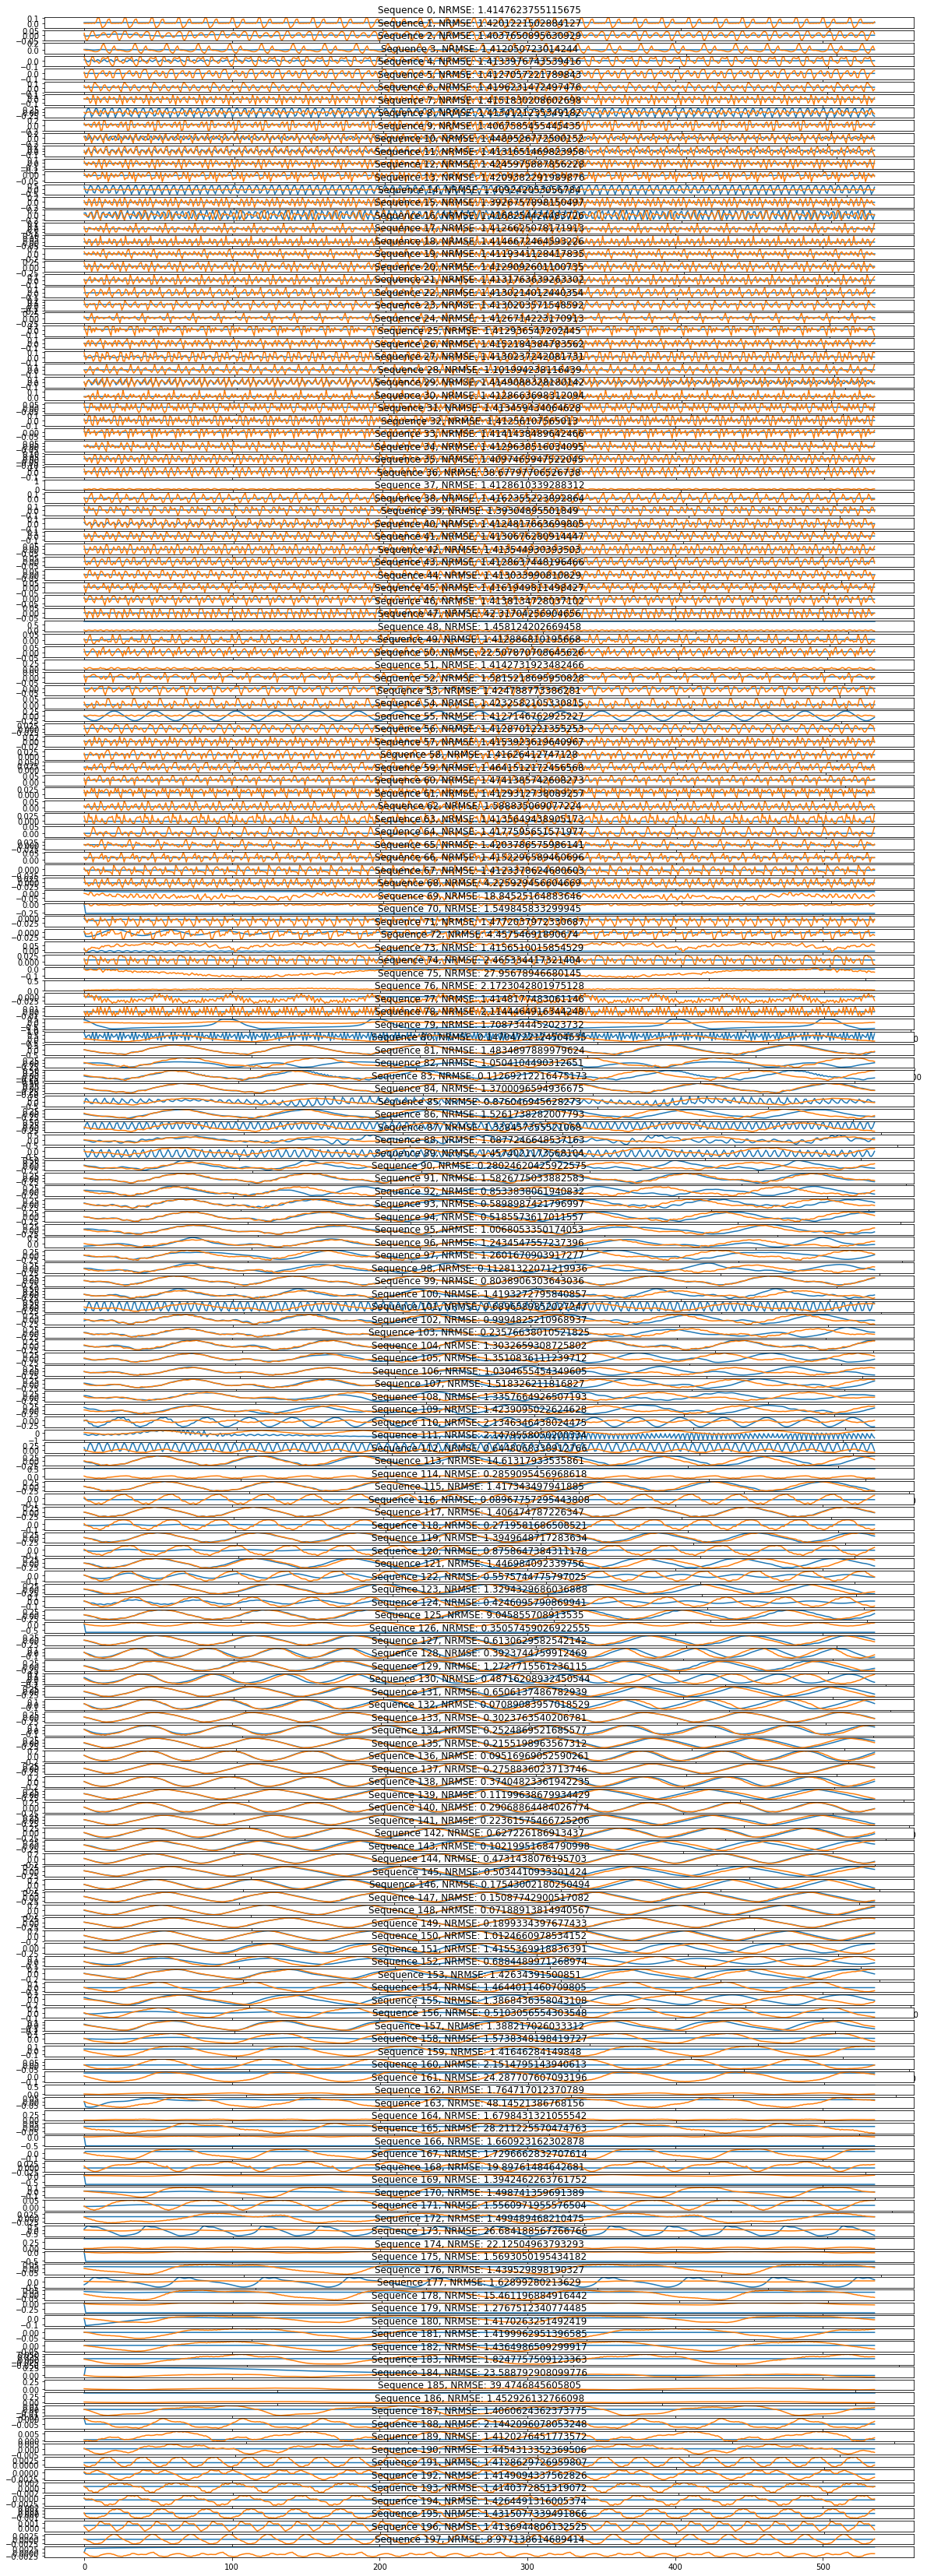

In [14]:
def plotConceptorPattern(p, C, net, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    z_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].shape[0]))
#     C = cNet['Cs'][0,0]
    x = 0.5 * np.random.randn(p['N'],1)
    z = x
    LR = np.diag(p['LR'])
    LROneMinus = np.diag(1.0 - p['LR'])
    for n in range(recallTestLength + p['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + net['Wbias'])))
        x = C.dot(z)
        xPrev = x
        if (n > p['washoutLength']):
            x_CTestPL[:,n-p['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-p['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-p['washoutLength'],i_pattern] = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([p['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:p['patts'][i_pattern].size*2],p['patts'][i_pattern])
    matchPoint = np.argmax(templateScan)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = nrmse(outputPattern, targetPattern) 
    print(score)
    plot(outputPattern)
    plot(targetPattern)
    return score
    
figsize(20,60)
scores = np.zeros(len(apertures))
for i_patt in range(len(apertures)):
    ax = subplot(len(apertures), 1, i_patt+1)
    scores[i_patt] = plotConceptorPattern(params, patternCs[i_patt], bestNet, maxPatternLen * 2, i_patt)
    ax.set_title("Sequence " + str(i_patt) + ", NRMSE: " + str(scores[i_patt]))    

plt.savefig(filepre("tests.pdf"))

3.307263899923065
[ 1.41476238  1.42012215  1.40376509  1.41205072  1.41339767  1.41270572
  1.41962315  1.41518302  1.41341212  1.40675855  1.44895268  1.41316515
  1.42459759  1.42093823  1.40924205  1.39267579  1.41682544  1.41266251
  1.41466725  1.41193411  1.41290926  1.41317636  1.4130214   1.41302036
  1.41267142  1.41293655  1.41521844  1.41302372  1.10199424  1.41490883
  1.41286637  1.41345943  1.41256108  1.41414385  1.41296385  1.40974659
 38.67797707  1.41286103  1.41623552  1.39304896  1.41248177  1.41306763
  1.41354493  1.41286374  1.41303399  1.41619498  1.41381347 42.31704257
  1.4581242   1.41288681 22.50787071  1.41427319  1.58152187  1.42478877
  1.42325821  1.41271468  1.41287012  1.41539236  1.41626413  1.46415122
  1.47413857  1.41293127  1.58883507  1.41356494  1.41775957  1.42037866
  1.41522966  1.41233786  4.22592946 18.84525165  1.54984583  1.4772038
  4.45754692  1.415651    2.46533442 27.95678947  2.17230428  1.41481775
  2.11444649  1.70873445  0.147047

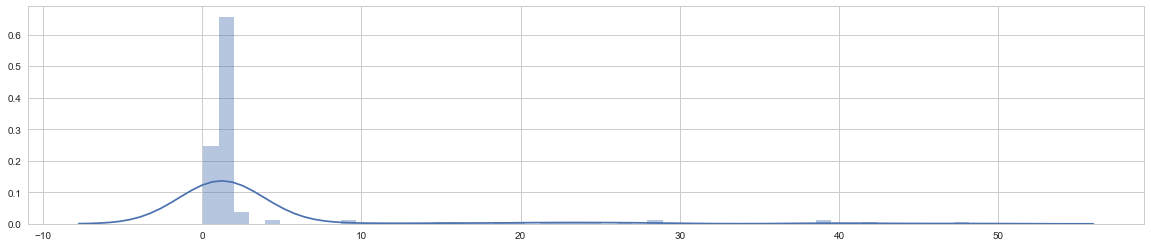

In [15]:
import seaborn as sns
sns.set(style="whitegrid")
print(np.mean(scores))
print(scores)
figsize(20,4)
# plot(sort(scores))
print(sort(scores))
# print(median(scores))
sns.distplot(scores)
plt.savefig(filepre("scoresDistrib.pdf"))

In [16]:

def render(p, lrMod=1.0, speed=1.0, xFade=0.05):
    audio = np.zeros(0)
    x = 0.5 * np.random.randn(p['N'],1)
    C = patternCs[0]
    
    LR = np.diag(p['LR'])
    LR = LR * lrMod
    LROneMinus = np.diag(1.0 - p['LR'])
    
    #run to washout
    for n in range(p['washoutLength']):
        xOld = x
        Wtarget = (bestNet['W'].dot(x))
        z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + bestNet['Wbias'])))
        x = C.dot(z)


    for i_patt in range(patterns.shape[0]):
#         print('=')
        xFadeTime=int(patterns[i_patt].shape[0] * xFade)
        for n in range(int(patterns[i_patt].shape[0] * speed)):
            C = patternCs[i_patt]
            v=int(patterns[i_patt].shape[0] * speed)
            stepL = min(v - n - 1, xFadeTime)
            stepU = min(n, xFadeTime)
            m1 = 1.0
            if(n > v-xFadeTime-1 and i_patt < patterns.shape[0]-1):
                m1 = (stepL + stepU) / (2*xFadeTime)
                nextC = patternCs[i_patt+1]
                C = (m1 * C) + ((1.0-m1) * nextC)
#                     print(m1)
            else:
                if (n < xFadeTime and i_patt > 0):
                    m1 = 0.5 - (n / (2*xFadeTime))
                    prevC = patternCs[i_patt-1]
                    C = (m1 * prevC) + ((1.0-m1) * C)
#                         print("-",m1)
#                 else:
#                     C = cNet['Cs'][0,0]
            
            xOld = x
            Wtarget = (bestNet['W'].dot(x))
            z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + bestNet['Wbias'])))
            x = C.dot(z)

            newSample = bestNet['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
            audio = np.concatenate((audio, newSample))
    return audio


print("done")

done


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


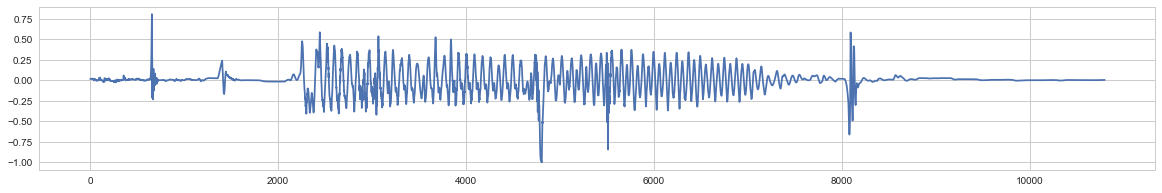

In [22]:
figsize(20,3)
audio = render(params)
plot(audio)
# plot(y[:audio.size])
plt.savefig(filepre('recon.pdf'))
librosa.output.write_wav(filepre("recon.wav"), librosa.resample(audio, sr, 44100), 44100)
Audio(data=audio,rate=sr)


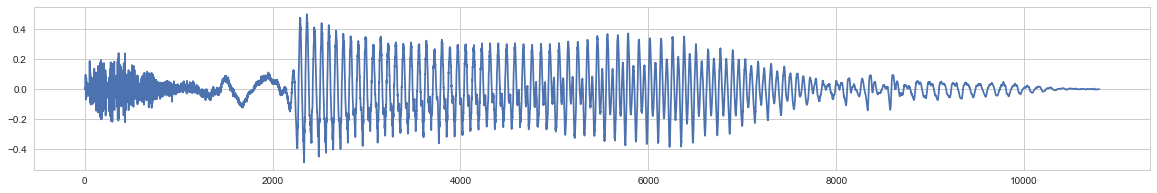

In [18]:
plot(y[:audio.size])
Audio(data=y[:audio.size],rate=sr)



1.4056249778174865


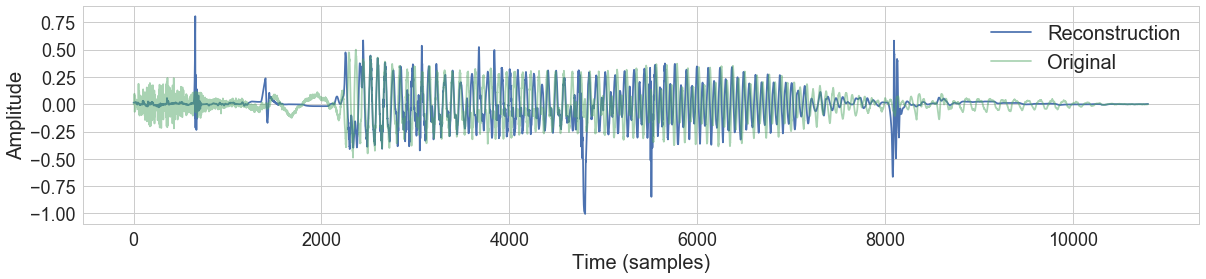

In [29]:
figsize(20,4)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plot(audio, alpha=1.0, label='Reconstruction')
plot(y[:audio.size], alpha=0.5, label='Original')
plt.legend(fontsize=20)
plt.savefig(filepre("reconCompare.pdf"), bbox_inches='tight')
print(nrmse(audio, y[:audio.size]))

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


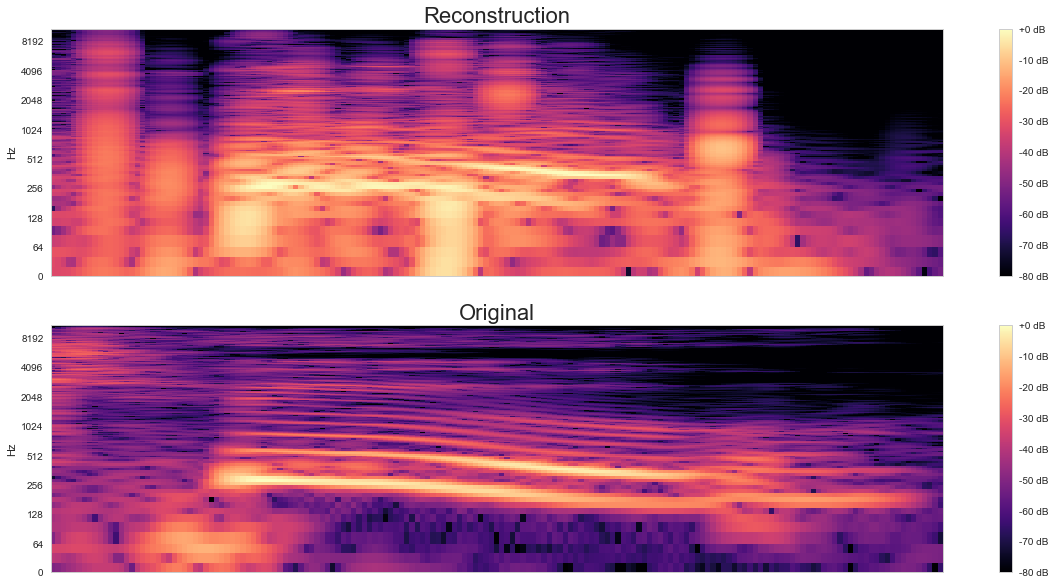

In [20]:
figsize(20,10)
import librosa.display
subplot(2,1,1)
CQT = librosa.amplitude_to_db(librosa.stft(audio, n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Reconstruction', fontsize=22)
subplot(2,1,2)
CQT = librosa.amplitude_to_db(librosa.stft(y[:audio.shape[0]], n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Original', fontsize=22)
plt.savefig(filepre("spectra.pdf"))